# Import librairies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Import dataset

In [2]:
df_final = pd.read_parquet('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/df_final_20250423.parquet')

# Exploration

In [3]:
df_final.head()

,id_technique,id,debit,longueur,taux_occupation,code_couleur,nom_du_troncon,etat_du_trafic,temps_de_parcours,vitesse,...,epsg_reg,etat_indice,geom_type,geom_coordinates,geo_point_2d_lon,geo_point_2d_lat,has_event_near_troncon,heure,pluie,is_weekend
0,1021-20250221T195200,1021,360,349,4.5,3,Riviere I2,fluide,67,19,...,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,19,True,False
1,6006-20250221T195200,6006,120,411,3.3,3,Republique P1,fluide,91,16,...,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,19,True,False
2,7128-20250221T195200,7128,300,180,3.7,3,Ingres P1,fluide,35,19,...,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,19,True,False
3,2128-20250221T195200,2128,480,208,5.8,3,Ingres I3,fluide,39,19,...,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,19,True,False
4,113-20250221T195200,113,120,304,1.6,3,Ste Luce I2,fluide,55,20,...,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,19,True,False


In [4]:
df_final.isna().sum().loc[df_final.isna().sum() > 0]

Series([], dtype: int64)

In [5]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120779 entries, 0 to 1120778
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   id_technique            1120779 non-null  object        
 1   id                      1120779 non-null  object        
 2   debit                   1120779 non-null  int64         
 3   longueur                1120779 non-null  int64         
 4   taux_occupation         1120779 non-null  float64       
 5   code_couleur            1120779 non-null  int64         
 6   nom_du_troncon          1120779 non-null  object        
 7   etat_du_trafic          1120779 non-null  object        
 8   temps_de_parcours       1120779 non-null  int64         
 9   vitesse                 1120779 non-null  int64         
 10  geo_point_2d            1120779 non-null  object        
 11  geometrie               1120779 non-null  object        
 12  shape_geo     

# Analyse exploratoire Taux d'occupation

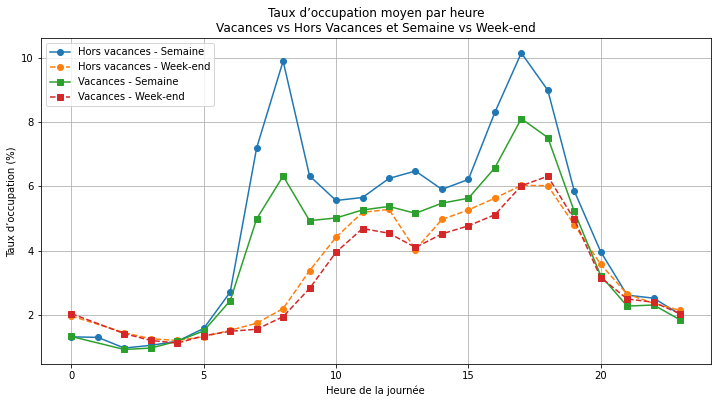

In [6]:
# Moyenne par heure, selon vacances et week-end :
mean_hour = df_final.groupby(['heure', 'is_vacances', 'is_weekend'])['taux_occupation'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))

# Hors vacances - semaine
plt.plot(
    mean_hour[(mean_hour['is_vacances'] == 0) & (mean_hour['is_weekend'] == 0)]['heure'],
    mean_hour[(mean_hour['is_vacances'] == 0) & (mean_hour['is_weekend'] == 0)]['taux_occupation'],
    label='Hors vacances - Semaine',
    linestyle='-', marker='o'
)

# Hors vacances - week-end
plt.plot(
    mean_hour[(mean_hour['is_vacances'] == 0) & (mean_hour['is_weekend'] == 1)]['heure'],
    mean_hour[(mean_hour['is_vacances'] == 0) & (mean_hour['is_weekend'] == 1)]['taux_occupation'],
    label='Hors vacances - Week-end',
    linestyle='--', marker='o'
)

# Vacances - semaine
plt.plot(
    mean_hour[(mean_hour['is_vacances'] == 1) & (mean_hour['is_weekend'] == 0)]['heure'],
    mean_hour[(mean_hour['is_vacances'] == 1) & (mean_hour['is_weekend'] == 0)]['taux_occupation'],
    label='Vacances - Semaine',
    linestyle='-', marker='s'
)

# Vacances - week-end
plt.plot(
    mean_hour[(mean_hour['is_vacances'] == 1) & (mean_hour['is_weekend'] == 1)]['heure'],
    mean_hour[(mean_hour['is_vacances'] == 1) & (mean_hour['is_weekend'] == 1)]['taux_occupation'],
    label='Vacances - Week-end',
    linestyle='--', marker='s'
)

plt.title('Taux d’occupation moyen par heure\nVacances vs Hors Vacances et Semaine vs Week-end')
plt.xlabel('Heure de la journée')
plt.ylabel('Taux d’occupation (%)')
plt.legend()
plt.grid(True)
plt.show()


1 - Hors vacances en semaine (courbe bleue) :
On observe 2 pics, un le matin entre 7h et 9h et un le soir entre 16h et 19h.
2 - Hors vacances en week-end (courbe orange) :
Plus 'plat' sans pic de circulation.
Creux le matin aux horaires de pic de la semaine
3 - En vacances en semaine (courbe verte) :
Suit le même schéma qu'hors vacances mais avec un taux d'occupation moyen plus faible
4 - En vacances en week-end (courbe rouge) :
Très similaires à la même courbe hors vacances.

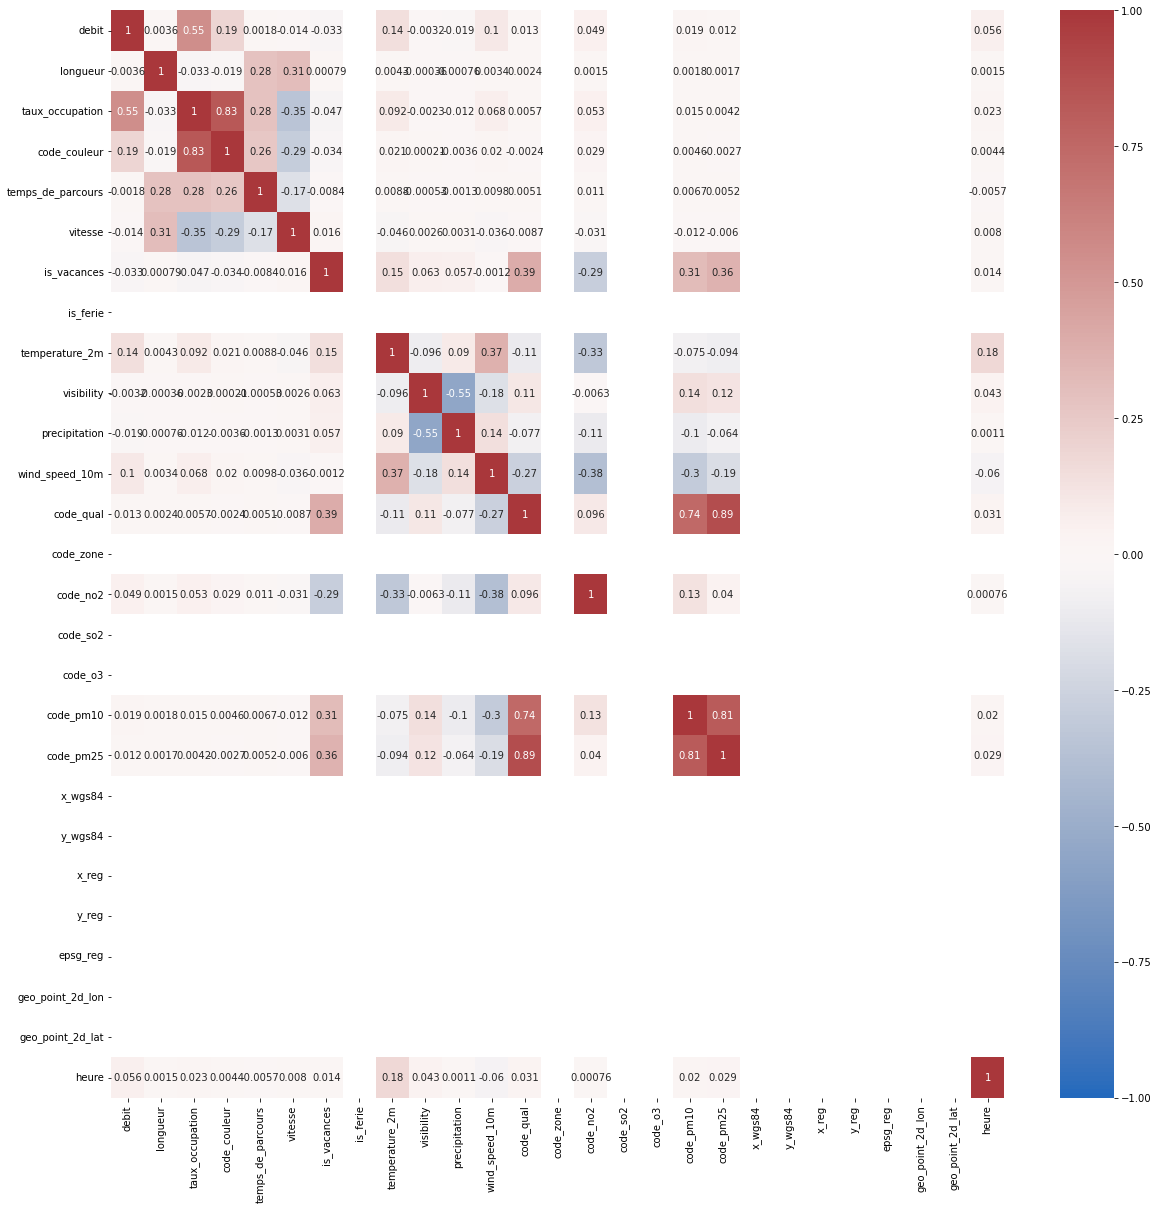

In [10]:
# Valeur numerique uniquement 
corr = df_final.select_dtypes('number').corr()

#Afficher une heatmap avec les colonnes corrélées 
plt.figure(figsize=(20,20))
sns.heatmap(corr,
            cmap = "vlag",
            center = 0,
            annot = True,
            vmin = -1,
            vmax = 1)
plt.show()

## Filtrer sur un tronçon pour commencer, hors vacances scolaires

In [11]:
df = df_final[(df_final['nom_du_troncon'] == 'Vannes I7') & (df_final['is_vacances'] == 0)]

### Remettre données en ordre chrono

IMPORTANT car chaque donnée dépend de celle qui la précède

In [12]:
df = df.sort_values('horodatage')
df = df.set_index('horodatage')

#### Vérification des Nan

In [13]:
df['taux_occupation'].isna().sum()

0

#### Fréquence des données

In [14]:
diffs = df.index.to_series().diff()

# Compter la fréquence de chaque intervalle
interval_counts = diffs.value_counts()
print(interval_counts)


horodatage
0 days 00:15:00    235
0 days 00:10:00    155
0 days 00:20:00    108
0 days 00:14:00     82
0 days 00:25:00     72
                  ... 
0 days 04:35:00      1
0 days 04:40:00      1
0 days 02:16:00      1
0 days 03:05:00      1
0 days 02:29:00      1
Name: count, Length: 73, dtype: int64


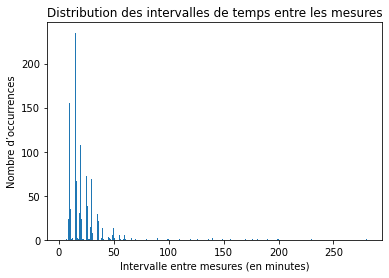

In [15]:
interval_counts.index = interval_counts.index.total_seconds() / 60  # convertir en minutes
plt.bar(interval_counts.index, interval_counts.values)
plt.xlabel('Intervalle entre mesures (en minutes)')
plt.ylabel('Nombre d’occurrences')
plt.title('Distribution des intervalles de temps entre les mesures')
plt.show()

### Resample des heures à 15 minutes et ingestion de données interpolées

In [16]:
df_resampled = df[['taux_occupation']].resample('15min').mean().interpolate()

#### Analyse de l'impact sur les données

In [17]:
print("Original :")
print(df['taux_occupation'].describe())
print("\nResamplé :")
print(df_resampled['taux_occupation'].describe())


Original :
count    1157.000000
mean       17.877010
std        19.994611
min         0.400000
25%         3.700000
50%        10.800000
75%        22.000000
max        91.600000
Name: taux_occupation, dtype: float64

Resamplé :
count    1822.000000
mean       14.957286
std        18.599754
min         0.400000
25%         1.928070
50%         7.900000
75%        18.300000
max        91.600000
Name: taux_occupation, dtype: float64


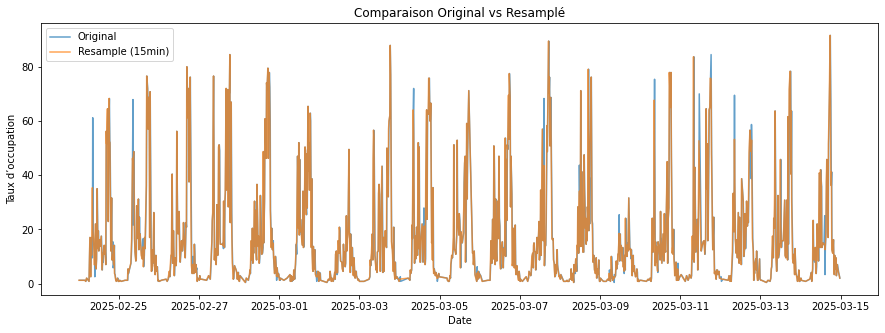

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['taux_occupation'], label='Original', alpha=0.7)
plt.plot(df_resampled.index, df_resampled['taux_occupation'], label='Resample (15min)', alpha=0.7)
plt.legend()
plt.title('Comparaison Original vs Resamplé')
plt.xlabel('Date')
plt.ylabel('Taux d’occupation')
plt.show()


On voit ici qu'il y a une perte d'information sur les pics de circulation

In [19]:
# Réinterpolation de l'original sur les timestamps resamplés
df_interp = df.reindex(df_resampled.index).interpolate()

# Supprimer les lignes où il reste des NaN (dans l'un ou l'autre)
common = pd.concat([df_interp['taux_occupation'], df_resampled['taux_occupation']], axis=1).dropna()
common.columns = ['original', 'resample']

# Calcul du MAE sans NaN
mae = mean_absolute_error(common['original'], common['resample'])
print(f"MAE (Original réinterpolé vs Resamplé) : {mae}")


MAE (Original réinterpolé vs Resamplé) : 12.59785834603353


<ipython-input-19-1a980911a4da>:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interp = df.reindex(df_resampled.index).interpolate()


Le MAE (Erreur Absolue Moyenne) mesure la distance moyenne entre les valeurs prédites et les valeurs réelles. Et ici elle est trop élevèe, le modèl se trompe en moyenne de 12.6 points sur une échelle qui monte jusqu’à 100.
Donc ça représente une erreur moyenne de presque 75% de la moyenne.

### Resample des heures à 10 minutes et ingestion de données interpolées

In [20]:
df_resampled_10min = df[['taux_occupation']].resample('10min').mean().interpolate()

#### Analyse d'impact

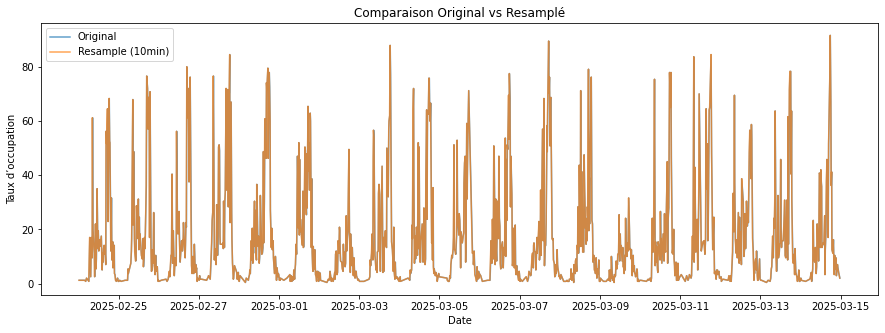

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['taux_occupation'], label='Original', alpha=0.7)
plt.plot(df_resampled_10min.index, df_resampled_10min['taux_occupation'], label='Resample (10min)', alpha=0.7)
plt.legend()
plt.title('Comparaison Original vs Resamplé')
plt.xlabel('Date')
plt.ylabel('Taux d’occupation')
plt.show()

le resemple cache complétement l'original, on peut penser que les pics sont mieux respectés

In [23]:
# Réinterpolation de l'original sur les timestamps resamplés
df_interp = df.reindex(df_resampled_10min.index).interpolate()

# Supprimer les lignes où il reste des NaN (dans l'un ou l'autre)
common = pd.concat([df_interp['taux_occupation'], df_resampled_10min['taux_occupation']], axis=1).dropna()
common.columns = ['original', 'resample']

# Calcul du MAE sans NaN
mae = mean_absolute_error(common['original'], common['resample'])
print(f"MAE (Original réinterpolé vs Resamplé) : {mae}")

MAE (Original réinterpolé vs Resamplé) : 13.053653265909638


<ipython-input-23-e2e2ed83bf3a>:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interp = df.reindex(df_resampled_10min.index).interpolate()


Le MAE est encore plus important qu'avec 15 minutes. On va tester sans interpolation

### Resample 15 et 10 minutes sans interpolation mais avec la moyenne

Forcer une fréquence régulière de 10 minutes.
Pour chaque créneau de 10 min, si plusieurs mesures tombent dedans, on fait la moyenne.
S’il n’y a pas de mesure dans un créneau : ça laisse des NaN (car on n’invente pas de valeurs).

In [24]:
df_resampled_no_interp = df[['taux_occupation']].resample('15min').mean()  # pas de interpolate()
# Supprimer les lignes où il reste des NaN (dans l'un ou l'autre)
common = pd.concat([df['taux_occupation'], df_resampled_no_interp['taux_occupation']], axis=1).dropna()
common.columns = ['original', 'resample']

# Calcul du MAE sans NaN
mae = mean_absolute_error(common['original'], common['resample'])
print(f"MAE (Original vs Resamplé sans interpolation) : {mae}")


MAE (Original vs Resamplé sans interpolation) : 0.2250000000000001


In [25]:
df_resampled_no_interp.isna().sum()

taux_occupation    719
dtype: int64

In [50]:
df_resampled_no_interp.head()

,taux_occupation
horodatage,
2025-02-24 00:20:00,1.2
2025-02-24 00:30:00,NaN
2025-02-24 00:40:00,NaN
2025-02-24 00:50:00,NaN
2025-02-24 01:00:00,NaN


In [26]:
df_resampled_no_interp = df[['taux_occupation']].resample('10min').mean()  # pas de interpolate()
# Supprimer les lignes où il reste des NaN (dans l'un ou l'autre)
common = pd.concat([df['taux_occupation'], df_resampled_no_interp['taux_occupation']], axis=1).dropna()
common.columns = ['original', 'resample']

# Calcul du MAE sans NaN
mae = mean_absolute_error(common['original'], common['resample'])
print(f"MAE (Original vs Resamplé sans interpolation) : {mae}")

MAE (Original vs Resamplé sans interpolation) : 0.0


Conclusion : L'interpolation cachait trop les pics et générait une trop grande perte d'info. Avec le resample, j'ai gééré des donnée de taux d'occupation vide que je dois choisir de remplir soit par ffill soit par interpolation ce qui peut fausser les données. 

## Arrondir au quart d'heure le plus proche

In [27]:
df['horodate_rounded'] = df.index.round('15min')
df_grouped = df.groupby('horodate_rounded')[['taux_occupation']].mean()

In [28]:
df.head()

,id_technique,id,debit,longueur,taux_occupation,code_couleur,nom_du_troncon,etat_du_trafic,temps_de_parcours,vitesse,...,etat_indice,geom_type,geom_coordinates,geo_point_2d_lon,geo_point_2d_lat,has_event_near_troncon,heure,pluie,is_weekend,horodate_rounded
horodatage,,,,,,,,,,,,,,,,,,,,,
2025-02-24 00:28:00,70-20250224T002800,70,60,295,1.2,3,Vannes I7,fluide,52,20,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,0,False,False,2025-02-24 00:30:00
2025-02-24 03:47:00,70-20250224T034700,70,60,295,1.2,3,Vannes I7,fluide,-1,-1,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,3,False,False,2025-02-24 03:45:00
2025-02-24 04:22:00,70-20250224T042200,70,60,295,0.8,3,Vannes I7,fluide,48,22,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,4,False,False,2025-02-24 04:15:00
2025-02-24 04:52:00,70-20250224T045200,70,120,295,2.0,3,Vannes I7,fluide,62,17,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,4,False,False,2025-02-24 04:45:00
2025-02-24 05:52:00,70-20250224T055200,70,60,295,1.2,3,Vannes I7,fluide,67,16,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,false,5,False,False,2025-02-24 05:45:00


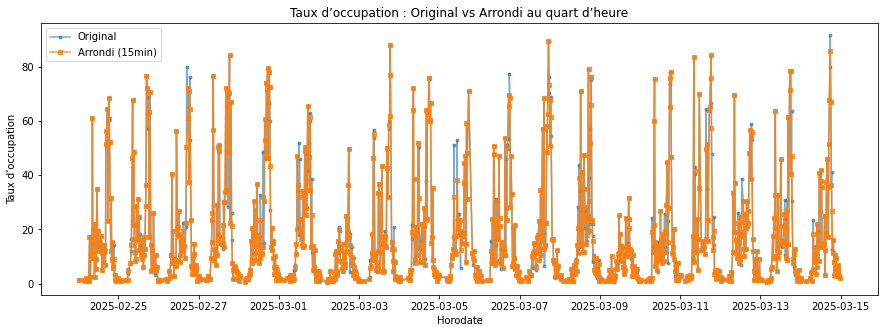

In [29]:
# Analyse de l'impact

plt.figure(figsize=(15, 5))

# Données originales
plt.plot(df.index, df['taux_occupation'], label='Original', alpha=0.6, marker='o', linestyle='-', markersize=3)

# Données arrondies + moyennées
plt.plot(df_grouped.index, df_grouped['taux_occupation'], label='Arrondi (15min)', alpha=0.8, marker='s', linestyle='-', markersize=4)

plt.legend()
plt.title('Taux d’occupation : Original vs Arrondi au quart d’heure')
plt.xlabel('Horodate')
plt.ylabel('Taux d’occupation')
plt.show()


In [30]:
mae = mean_absolute_error(common['original'], common['resample'])
print(f"MAE : {mae:.2f}")

MAE : 0.00


Globalement, la forme de la série est respectée, mais il ya une perte d’info fine sur les pics violents.

## Essai avec 10 min

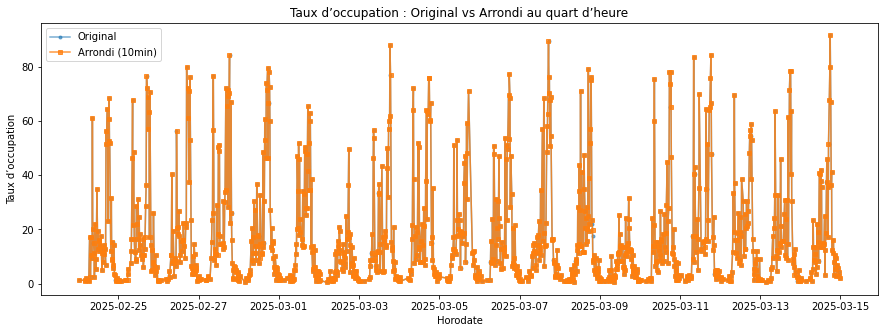

In [31]:
# Essai à 10 minutes
df['horodate_rounded'] = df.index.round('10min')
# Grouper si jamais 2 heure se retrouve être identique
df_grouped = df.groupby('horodate_rounded')[['taux_occupation']].mean()

# Analyse de l'impact

plt.figure(figsize=(15, 5))

# Données originales
plt.plot(df.index, df['taux_occupation'], label='Original', alpha=0.6, marker='o', linestyle='-', markersize=3)

# Données arrondies + moyennées
plt.plot(df_grouped.index, df_grouped['taux_occupation'], label='Arrondi (10min)', alpha=0.8, marker='s', linestyle='-', markersize=4)

plt.legend()
plt.title('Taux d’occupation : Original vs Arrondi au quart d’heure')
plt.xlabel('Horodate')
plt.ylabel('Taux d’occupation')
plt.show()

Visuellement, la série orange (arrondie) colle plus près de la série originale (bleue) que dans le cas du quart d’heure.
Les pics sont mieux respectés : moins d'info perdu

In [32]:
# Visualiser l'erreur
# On ajoute la valeur moyenne calculée à chaque point original (via join)
df_with_grouped = df[['taux_occupation', 'horodate_rounded']].merge(
    df_grouped, left_on='horodate_rounded', right_index=True, suffixes=('', '_rounded')
)
# Calcul de l'erreur (différence absolue)
df_with_grouped['abs_error'] = abs(df_with_grouped['taux_occupation'] - df_with_grouped['taux_occupation_rounded'])

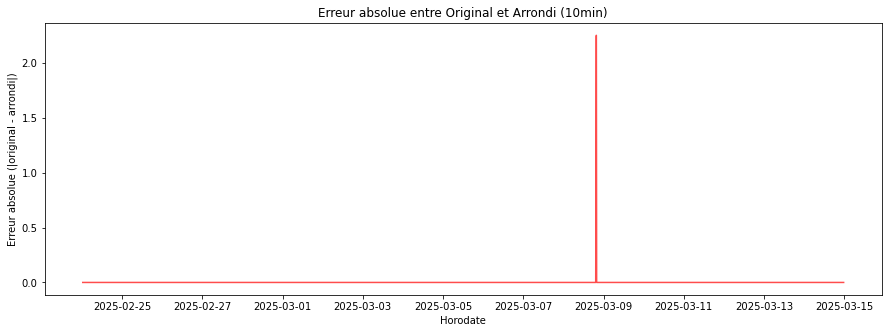

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(df_with_grouped.index, df_with_grouped['abs_error'], color='red', alpha=0.7)
plt.title('Erreur absolue entre Original et Arrondi (10min)')
plt.xlabel('Horodate')
plt.ylabel('Erreur absolue (|original - arrondi|)')
plt.show()


L'arrondi à 10 minutes respecte très bien les valeurs originales dans presque tous les cas.

Mais parfois, il y a plusieurs mesures différentes dans la même tranche de 10 minutes, et avec la moyenne, on perd l’amplitude de certaines variations rapides 

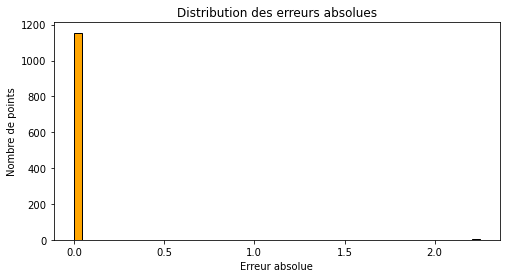

In [34]:
# Histogramme des erreurs
plt.figure(figsize=(8, 4))
plt.hist(df_with_grouped['abs_error'], bins=50, color='orange', edgecolor='black')
plt.title('Distribution des erreurs absolues')
plt.xlabel('Erreur absolue')
plt.ylabel('Nombre de points')
plt.show()


Écrasante majorité des erreurs très faibles (quasi nulles).
Quelques rares grosses erreurs (probablement des cas où plusieurs valeurs très différentes sont tombées dans le même créneau de 10 min).

In [35]:
# Repérer les 10 cas avec l’erreur la plus forte
df_with_grouped.sort_values('abs_error', ascending=False).head(10)

,taux_occupation,horodate_rounded,taux_occupation_rounded,abs_error
horodatage,,,,
2025-03-08 19:42:00,17.5,2025-03-08 19:40:00,19.75,2.25
2025-03-08 19:38:00,22.0,2025-03-08 19:40:00,19.75,2.25
2025-03-08 04:42:00,0.8,2025-03-08 04:40:00,0.80,0.00
2025-03-08 19:18:00,23.3,2025-03-08 19:20:00,23.30,0.00
2025-03-08 18:52:00,76.2,2025-03-08 18:50:00,76.20,0.00
2025-03-08 18:37:00,75.0,2025-03-08 18:40:00,75.00,0.00
2025-03-08 18:23:00,57.0,2025-03-08 18:20:00,57.00,0.00
2025-03-08 18:12:00,52.0,2025-03-08 18:10:00,52.00,0.00
2025-03-08 17:52:00,22.0,2025-03-08 17:50:00,22.00,0.00


Les MAE sont très faible, ce qui signifie que l'ecart entre le reel est l'arrondi est faible.
Cette méthode conserve le mieux l'intégrité des données

# Conclusion
La méthode round est retenue car 
- Pas de données artificielles
- Pas besoin de remplir les trous avec des valeurs inventées (comme le ferait une interpolation).
- On garde uniquement les points réellement mesurés, mais on réaligne leurs horaires sur une grille régulière.

# NOUVELLE APPROCHE

# ÉTAPE 1 — Chargement des données 

In [80]:
import os
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()

user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
dbname = os.getenv("DB_NAME")

DATABASE_URL = f"postgresql://{user}:{password}@{host}:{port}/{dbname}?sslmode=require"

def fetch_table_from_trafic_db(table_name) :
    '''
        Récupère toutes les données d'une table spécifique depuis la base de données de trafic.
        
        Args:
            table_name (str): Le nom de la table à récupérer.
            
        Returns:
            pd.DataFrame: Un DataFrame contenant les données de la table demandée.
    '''
    engine = create_engine(DATABASE_URL)
    query = f"SELECT * FROM {table_name};" 
    df = pd.read_sql(query, engine)
    return df

In [81]:
df_trafic = fetch_table_from_trafic_db('trafic_routier')

In [82]:
df_events = fetch_table_from_trafic_db('events_data')

In [83]:
df_matching_troncon = fetch_table_from_trafic_db('matching_event_troncon')

In [84]:
df_pollution_data = fetch_table_from_trafic_db('pollution_data')

In [85]:
df_weather_data = fetch_table_from_trafic_db('weather_data')

In [86]:
df_holidays = fetch_table_from_trafic_db('weekday_holidays')

# ÉTAPE 2 — Préparation du dataset trafic 

In [87]:
df_trafic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554761 entries, 0 to 1554760
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   id_technique       1554761 non-null  object        
 1   id                 1554761 non-null  int64         
 2   debit              1554761 non-null  int64         
 3   longueur           1554761 non-null  int64         
 4   taux_occupation    1554761 non-null  float64       
 5   code_couleur       1554761 non-null  int64         
 6   nom_du_troncon     1554761 non-null  object        
 7   etat_du_trafic     1554761 non-null  object        
 8   temps_de_parcours  1554761 non-null  int64         
 9   vitesse            1554761 non-null  int64         
 10  geo_point_2d       1554761 non-null  object        
 11  geometrie          1554761 non-null  object        
 12  shape_geo          1554761 non-null  object        
 13  horodatage         1554761 

In [88]:
df_trafic['etat_du_trafic'].value_counts()

etat_du_trafic
Fluide         1088529
Indéterminé     433982
Dense            14205
Bloqué           10588
Saturé            7457
Name: count, dtype: int64

In [89]:
# Enleve les indeterminé
df_trafic = df_trafic[df_trafic['etat_du_trafic'].str.lower() != 'indéterminé']

In [ ]:
# Gérer les valeurs nulles - 1
cols_to_clean = ['taux_occupation', 'debit', 'vitesse', 'temps_de_parcours']
df_trafic[cols_to_clean] = df_trafic[cols_to_clean].replace(-1, np.nan)

In [120]:
df_trafic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1120779 entries, 1 to 1554760
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   id_technique       1120779 non-null  object        
 1   id                 1120779 non-null  int64         
 2   debit              1120779 non-null  int64         
 3   longueur           1120779 non-null  int64         
 4   taux_occupation    1120779 non-null  float64       
 5   code_couleur       1120779 non-null  int64         
 6   nom_du_troncon     1120779 non-null  object        
 7   etat_du_trafic     1120779 non-null  object        
 8   temps_de_parcours  1116025 non-null  float64       
 9   vitesse            1116025 non-null  float64       
 10  geo_point_2d       1120779 non-null  object        
 11  geometrie          1120779 non-null  object        
 12  shape_geo          1120779 non-null  object        
 13  horodatage         1120779 non-n

In [121]:
df_trafic = df_trafic[~(df_trafic['vitesse'].isna() & df_trafic['temps_de_parcours'].isna())]

In [122]:
df_trafic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1116025 entries, 1 to 1554760
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   id_technique       1116025 non-null  object        
 1   id                 1116025 non-null  int64         
 2   debit              1116025 non-null  int64         
 3   longueur           1116025 non-null  int64         
 4   taux_occupation    1116025 non-null  float64       
 5   code_couleur       1116025 non-null  int64         
 6   nom_du_troncon     1116025 non-null  object        
 7   etat_du_trafic     1116025 non-null  object        
 8   temps_de_parcours  1116025 non-null  float64       
 9   vitesse            1116025 non-null  float64       
 10  geo_point_2d       1116025 non-null  object        
 11  geometrie          1116025 non-null  object        
 12  shape_geo          1116025 non-null  object        
 13  horodatage         1116025 non-n

## Arrondir au quart d'heure le plus proche

In [123]:
def round_to_nearest_quarter_hour(dt):
    """Arrondit un datetime au quart d'heure le plus proche."""
    minute = dt.minute
    rounded_minute = 15 * round(minute / 15)
    return dt.replace(minute=0, second=0, microsecond=0) + pd.Timedelta(minutes=rounded_minute)

def nettoyer_donnees_timestamps(df, time_col='horodatage', troncon_col='nom_du_troncon'):
    """
    Étape 1 : arrondir les heures, supprimer les doublons tronçon+heure_arrondie
    en gardant la mesure la plus proche de l'heure réelle.
    """
    # 1. S'assurer que la colonne de temps est bien au format datetime
    df[time_col] = pd.to_datetime(df[time_col])

    # 2. Créer la colonne arrondie au quart d'heure
    df['heure_arrondie'] = df[time_col].apply(round_to_nearest_quarter_hour)

    # 3. Calculer l'écart entre l'heure réelle et arrondie
    df['ecart'] = (df[time_col] - df['heure_arrondie']).abs()

    # 4. Garder la ligne la plus proche de l’heure arrondie (par tronçon et quart d'heure)
    df = df.sort_values(by=[troncon_col, 'heure_arrondie', 'ecart'])
    df = df.drop_duplicates(subset=[troncon_col, 'heure_arrondie'], keep='first')

    # 5. Supprimer la colonne intermédiaire d’écart
    df = df.drop(columns='ecart')

    return df


In [124]:
df_clean = nettoyer_donnees_timestamps(df_trafic)

In [125]:
df_clean.head()

,id_technique,id,debit,longueur,taux_occupation,code_couleur,nom_du_troncon,etat_du_trafic,temps_de_parcours,vitesse,geo_point_2d,geometrie,shape_geo,horodatage,type_geo,coordinates_geo,horodatage_date,heure_arrondie
1522970,5149-2025-02-16 20:22:00.000,5149,240,478,2.9,3,3 Continents I,Fluide,85.0,20.0,"{47.19769602892261,-1.56218293942916}","{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 20:22:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16,2025-02-16 20:15:00
1522133,5149-2025-02-16 20:27:00.000,5149,180,478,1.6,3,3 Continents I,Fluide,81.0,21.0,"{47.19769602892261,-1.56218293942916}","{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 20:27:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16,2025-02-16 20:30:00
1520728,5149-2025-02-16 20:42:00.000,5149,60,478,2.0,3,3 Continents I,Fluide,84.0,20.0,"{47.19769602892261,-1.56218293942916}","{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 20:42:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16,2025-02-16 20:45:00
1519312,5149-2025-02-16 21:02:00.000,5149,240,478,2.9,3,3 Continents I,Fluide,83.0,21.0,"{47.19769602892261,-1.56218293942916}","{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 21:02:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16,2025-02-16 21:00:00
1518455,5149-2025-02-17 05:58:00.000,5149,60,478,0.8,3,3 Continents I,Fluide,81.0,21.0,"{47.19769602892261,-1.56218293942916}","{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-17 05:58:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-17,2025-02-17 06:00:00


## Vérification

In [ ]:
def comparer_courbe_trafic_par_heure(df_orig, df_clean, time_col='heure_arrondie', target_col='taux_occupation'):
    """
    Compare la courbe moyenne de trafic (taux d'occupation) par heure entre deux DataFrames :
    - df_orig : jeu de données original (avec trous)
    - df_clean : jeu interpolé/complété
    Affiche une courbe comparative pour vérifier la cohérence.
    """
    # Extraire l'heure pour les deux DataFrames
    df_orig = df_orig.copy()
    df_clean = df_clean.copy()
    df_orig['heure'] = pd.to_datetime(df_orig[time_col]).dt.hour
    df_clean['heure'] = pd.to_datetime(df_clean[time_col]).dt.hour

    # Moyenne horaire
    courbe_orig = df_orig.groupby('heure')[target_col].mean()
    courbe_clean = df_clean.groupby('heure')[target_col].mean()

    # Tracé
    plt.figure(figsize=(10, 5))
    plt.plot(courbe_orig.index, courbe_orig.values, label='Original', marker='o')
    plt.plot(courbe_clean.index, courbe_clean.values, label='Nettoyé', marker='x')
    plt.title("Comparaison des courbes de trafic par heure")
    plt.xlabel("Heure")
    plt.ylabel("Taux d'occupation moyen")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return courbe_orig, courbe_clean


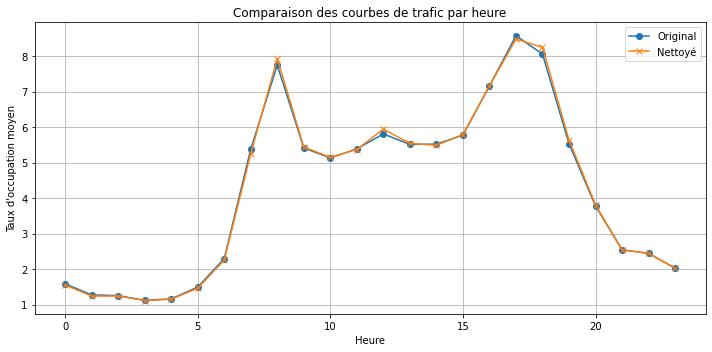

In [133]:
courbe_orig, courbe_clean = comparer_courbe_trafic_par_heure(df_trafic, df_clean)

# ÉTAPE 2 — Génération des lignes manquantes

In [126]:
def completer_index_horaire(df, time_col='heure_arrondie', troncon_col='nom_du_troncon', freq='15min'):
    """
    Étape 2 : créer un DataFrame avec tous les horaires possibles à 15min près pour chaque tronçon.
    """
    # 1. Liste des tronçons
    troncons = df[troncon_col].unique()

    # 2. Index temporel complet sur la période de données
    time_range = pd.date_range(df[time_col].min(), df[time_col].max(), freq=freq)

    # 3. Produit cartésien : tronçons x horaires
    full_index = pd.MultiIndex.from_product(
        [troncons, time_range],
        names=[troncon_col, time_col]
    )

    # 4. Créer un DataFrame avec cet index
    df_complet = pd.DataFrame(index=full_index).reset_index()

    # 5. Fusion avec les données existantes (outer merge)
    df_merge = df_complet.merge(df, on=[troncon_col, time_col], how='left')

    return df_merge


In [127]:
df_full = completer_index_horaire(df_clean)

In [128]:
df_full.head()

,nom_du_troncon,heure_arrondie,id_technique,id,debit,longueur,taux_occupation,code_couleur,etat_du_trafic,temps_de_parcours,vitesse,geo_point_2d,geometrie,shape_geo,horodatage,type_geo,coordinates_geo,horodatage_date
0,3 Continents I,2025-02-16 20:15:00,5149-2025-02-16 20:22:00.000,5149.0,240.0,478.0,2.9,3.0,Fluide,85.0,20.0,"{47.19769602892261,-1.56218293942916}","{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 20:22:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16
1,3 Continents I,2025-02-16 20:30:00,5149-2025-02-16 20:27:00.000,5149.0,180.0,478.0,1.6,3.0,Fluide,81.0,21.0,"{47.19769602892261,-1.56218293942916}","{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 20:27:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16
2,3 Continents I,2025-02-16 20:45:00,5149-2025-02-16 20:42:00.000,5149.0,60.0,478.0,2.0,3.0,Fluide,84.0,20.0,"{47.19769602892261,-1.56218293942916}","{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 20:42:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16
3,3 Continents I,2025-02-16 21:00:00,5149-2025-02-16 21:02:00.000,5149.0,240.0,478.0,2.9,3.0,Fluide,83.0,21.0,"{47.19769602892261,-1.56218293942916}","{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 21:02:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16
4,3 Continents I,2025-02-16 21:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN


### Vérification 

In [134]:
# 1. Période globale
debut = df_full['heure_arrondie'].min()
fin = df_full['heure_arrondie'].max()
time_range = pd.date_range(start=debut, end=fin, freq='15min')

# 2. Tronçons uniques
troncons = df_full['nom_du_troncon'].unique()

# 3. Index attendu : produit cartésien
index_attendu = pd.MultiIndex.from_product(
    [troncons, time_range],
    names=['nom_du_troncon', 'heure_arrondie']
)
# 4. Index réel
index_reel = pd.MultiIndex.from_frame(df_full[['nom_du_troncon', 'heure_arrondie']])

# 5. Lignes manquantes = attendues mais absentes
manquantes = index_attendu.difference(index_reel)

print(f"Lignes manquantes : {len(manquantes)}")

Lignes manquantes : 0


In [141]:
df_full.head()

,nom_du_troncon,heure_arrondie,id_technique,id,debit,longueur,taux_occupation,code_couleur,etat_du_trafic,temps_de_parcours,vitesse,geo_point_2d,geometrie,shape_geo,horodatage,type_geo,coordinates_geo,horodatage_date
0,3 Continents I,2025-02-16 20:15:00,5149-2025-02-16 20:22:00.000,5149.0,240.0,478.0,2.9,3.0,Fluide,85.0,20.0,"{47.19769602892261,-1.56218293942916}","{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 20:22:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16
1,3 Continents I,2025-02-16 20:30:00,5149-2025-02-16 20:27:00.000,5149.0,180.0,478.0,1.6,3.0,Fluide,81.0,21.0,"{47.19769602892261,-1.56218293942916}","{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 20:27:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16
2,3 Continents I,2025-02-16 20:45:00,5149-2025-02-16 20:42:00.000,5149.0,60.0,478.0,2.0,3.0,Fluide,84.0,20.0,"{47.19769602892261,-1.56218293942916}","{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 20:42:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16
3,3 Continents I,2025-02-16 21:00:00,5149-2025-02-16 21:02:00.000,5149.0,240.0,478.0,2.9,3.0,Fluide,83.0,21.0,"{47.19769602892261,-1.56218293942916}","{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 21:02:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16
4,3 Continents I,2025-02-16 21:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT


# ÉTAPE 3 — Jointure

In [142]:
df_full['horodatage_date'] = df_full['heure_arrondie'].dt.date

In [143]:
df_full['horodatage_date'] = pd.to_datetime(df_full['horodatage_date'])

In [144]:
df_full.isna().sum()

nom_du_troncon            0
heure_arrondie            0
id_technique         914792
id                   914792
debit                914792
longueur             914792
taux_occupation      914792
code_couleur         914792
etat_du_trafic       914792
temps_de_parcours    914792
vitesse              914792
geo_point_2d         914792
geometrie            914792
shape_geo            914792
horodatage           914792
type_geo             914792
coordinates_geo      914792
horodatage_date           0
dtype: int64

## Holidays

In [145]:
df_holidays['dates'] = pd.to_datetime(df_holidays['dates'])
df_trafic_holidays = pd.merge(df_full, df_holidays,
                              how = 'left',
                              left_on = df_full['horodatage_date'],
                              right_on = 'dates')

In [146]:
df_trafic_holidays.head()

,nom_du_troncon,heure_arrondie,id_technique,id,debit,longueur,taux_occupation,code_couleur,etat_du_trafic,temps_de_parcours,...,geometrie,shape_geo,horodatage,type_geo,coordinates_geo,horodatage_date,dates,jour,is_vacances,is_ferie
0,3 Continents I,2025-02-16 20:15:00,5149-2025-02-16 20:22:00.000,5149.0,240.0,478.0,2.9,3.0,Fluide,85.0,...,"{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 20:22:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16,2025-02-16,Sunday,1,0
1,3 Continents I,2025-02-16 20:30:00,5149-2025-02-16 20:27:00.000,5149.0,180.0,478.0,1.6,3.0,Fluide,81.0,...,"{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 20:27:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16,2025-02-16,Sunday,1,0
2,3 Continents I,2025-02-16 20:45:00,5149-2025-02-16 20:42:00.000,5149.0,60.0,478.0,2.0,3.0,Fluide,84.0,...,"{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 20:42:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16,2025-02-16,Sunday,1,0
3,3 Continents I,2025-02-16 21:00:00,5149-2025-02-16 21:02:00.000,5149.0,240.0,478.0,2.9,3.0,Fluide,83.0,...,"{{-1.561753941619585,47.19982899909781},{-1.56...",LineString,2025-02-16 21:02:00,Point,"{-1.56218293942916,47.19769602892261}",2025-02-16,2025-02-16,Sunday,1,0
4,3 Continents I,2025-02-16 21:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,NaN,NaN,2025-02-16,2025-02-16,Sunday,1,0


## Weather

In [147]:
# Arrondir à l'heure la plus proche pour matcher avec le dataset weather
df_trafic_holidays['rounded_horodatage'] = df_trafic_holidays['heure_arrondie'].dt.round('h')

In [148]:
df_trafic_holidays_weather = pd.merge(df_trafic_holidays,df_weather_data,
                                                      how = 'left',
                                                      left_on = 'rounded_horodatage',
                                                      right_on = 'date')

In [149]:
df_trafic_holidays_weather.head()

,nom_du_troncon,heure_arrondie,id_technique,id,debit,longueur,taux_occupation,code_couleur,etat_du_trafic,temps_de_parcours,...,dates,jour,is_vacances,is_ferie,rounded_horodatage,date,temperature_2m,visibility,precipitation,wind_speed_10m
0,3 Continents I,2025-02-16 20:15:00,5149-2025-02-16 20:22:00.000,5149.0,240.0,478.0,2.9,3.0,Fluide,85.0,...,2025-02-16,Sunday,1,0,2025-02-16 20:00:00,2025-02-16 20:00:00,7.1305,24140.0,0.0,4.349896
1,3 Continents I,2025-02-16 20:30:00,5149-2025-02-16 20:27:00.000,5149.0,180.0,478.0,1.6,3.0,Fluide,81.0,...,2025-02-16,Sunday,1,0,2025-02-16 20:00:00,2025-02-16 20:00:00,7.1305,24140.0,0.0,4.349896
2,3 Continents I,2025-02-16 20:45:00,5149-2025-02-16 20:42:00.000,5149.0,60.0,478.0,2.0,3.0,Fluide,84.0,...,2025-02-16,Sunday,1,0,2025-02-16 21:00:00,2025-02-16 21:00:00,6.4305,24140.0,0.0,5.091168
3,3 Continents I,2025-02-16 21:00:00,5149-2025-02-16 21:02:00.000,5149.0,240.0,478.0,2.9,3.0,Fluide,83.0,...,2025-02-16,Sunday,1,0,2025-02-16 21:00:00,2025-02-16 21:00:00,6.4305,24140.0,0.0,5.091168
4,3 Continents I,2025-02-16 21:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2025-02-16,Sunday,1,0,2025-02-16 21:00:00,2025-02-16 21:00:00,6.4305,24140.0,0.0,5.091168


In [150]:
df_trafic_holidays_weather.isna().sum()

nom_du_troncon             0
heure_arrondie             0
id_technique          914792
id                    914792
debit                 914792
longueur              914792
taux_occupation       914792
code_couleur          914792
etat_du_trafic        914792
temps_de_parcours     914792
vitesse               914792
geo_point_2d          914792
geometrie             914792
shape_geo             914792
horodatage            914792
type_geo              914792
coordinates_geo       914792
horodatage_date            0
dates                      0
jour                       0
is_vacances                0
is_ferie                   0
rounded_horodatage         0
date                       0
temperature_2m             0
visibility                 0
precipitation              0
wind_speed_10m             0
dtype: int64

## Polution

In [151]:
df_pollution_data['date_ech'] = pd.to_datetime(df_pollution_data['date_ech'])

In [152]:
df_trafic_holidays_weather_pollution = pd.merge(df_trafic_holidays_weather,df_pollution_data,
                                                how = 'left', 
                                                left_on = 'horodatage_date',
                                                right_on = 'date_ech')

In [153]:
df_trafic_holidays_weather_pollution.isna().sum()

nom_du_troncon             0
heure_arrondie             0
id_technique          914792
id                    914792
debit                 914792
longueur              914792
taux_occupation       914792
code_couleur          914792
etat_du_trafic        914792
temps_de_parcours     914792
vitesse               914792
geo_point_2d          914792
geometrie             914792
shape_geo             914792
horodatage            914792
type_geo              914792
coordinates_geo       914792
horodatage_date            0
dates                      0
jour                       0
is_vacances                0
is_ferie                   0
rounded_horodatage         0
date                       0
temperature_2m             0
visibility                 0
precipitation              0
wind_speed_10m             0
gml_id                     0
date_ech                   0
code_qual                  0
lib_qual                   0
coul_qual                  0
date_dif                   0
source        

## Events

In [ ]:
lieux_spectacle_gde_capacite = [
    "Stade de la Beaujoire Louis Fonteneau",
    "Cité internationale des Congrès",
    "Palais des Sports Beaulieu",
]

df_matching_troncon_filtered = df_matching_troncon[df_matching_troncon['event_location_name'].isin(lieux_spectacle_gde_capacite)].copy()

In [158]:
df_matching_troncon_filtered['event_location_id'] = df_matching_troncon_filtered['event_location_id'].astype('str')

In [159]:
df_events['location_uid'] = df_events['location_uid'].astype('str')

In [172]:
df_event_troncon = pd.merge(df_events,df_matching_troncon_filtered,
                            how = 'left', 
                            left_on = 'location_uid',
                            right_on = 'event_location_id')

In [175]:
df_event_troncon.drop(columns=['index', 'nom_du_troncon', 'event_location_name', 'event_location_id'], inplace = True)

In [181]:
df_event_troncon['id_du_troncon'] = df_event_troncon['id_du_troncon'].astype('str')
df_event_troncon['id_du_troncon'] = df_event_troncon['id_du_troncon'].str.replace('.0', '').str.strip()

In [182]:
df_trafic_holidays_weather_pollution['id'] = df_trafic_holidays_weather_pollution['id'].astype('str')
df_trafic_holidays_weather_pollution['id'] = df_trafic_holidays_weather_pollution['id'].str.replace('.0', '').str.strip()

In [183]:
def match_events(row, df_event):
    troncon_id  = row['id']
    horodatage  = row['heure_arrondie']

    # filter once per row
    events = df_event[df_event['id_du_troncon'] == troncon_id]

    for _, event in events.iterrows():
        start_window_start = event['startdate'] - pd.Timedelta(minutes=15)
        start_window_end   = event['startdate'] + pd.Timedelta(minutes=15)
        end_window_end     = event['enddate']   + pd.Timedelta(minutes=15)

        if (start_window_start <= horodatage <= start_window_end) \
        or (event['enddate'] <= horodatage <= end_window_end):
            return pd.Series({
                'has_event_near_troncon': event['has_event_near_troncon'],
                'name':                   event['name'],
                'description':            event['description'],
                'startdate':              event['startdate'],
                'enddate':                event['enddate'],
                'location_name':          event['location_name']
            })

    # si aucun événement
    return pd.Series({
        'has_event_near_troncon': False,
        'name':                   None,
        'description':            None,
        'startdate':              pd.NaT,
        'enddate':                pd.NaT,
        'location_name':          None
    })

# liste des colonnes à ajouter
cols = [
    'has_event_near_troncon',
    'name',
    'description',
    'startdate',
    'enddate',
    'location_name'
]

# on applique et on étend en DataFrame
matched = df_trafic_holidays_weather_pollution.apply(
    match_events,
    axis=1,
    df_event=df_event_troncon,
    result_type='expand'
)

# on assigne les 6 colonnes d'un coup
df_trafic_holidays_weather_pollution[cols] = matched

In [184]:
df_trafic_holidays_weather_pollution

,nom_du_troncon,heure_arrondie,id_technique,id,debit,longueur,taux_occupation,code_couleur,etat_du_trafic,temps_de_parcours,...,geom_type,geom_coordinates,geo_point_2d_lon,geo_point_2d_lat,has_event_near_troncon,name,description,startdate,enddate,location_name
0,3 Continents I,2025-02-16 20:15:00,5149-2025-02-16 20:22:00.000,5149,240.0,478.0,2.9,3.0,Fluide,85.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,None,None,NaT,NaT,None
1,3 Continents I,2025-02-16 20:30:00,5149-2025-02-16 20:27:00.000,5149,180.0,478.0,1.6,3.0,Fluide,81.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,None,None,NaT,NaT,None
2,3 Continents I,2025-02-16 20:45:00,5149-2025-02-16 20:42:00.000,5149,60.0,478.0,2.0,3.0,Fluide,84.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,None,None,NaT,NaT,None
3,3 Continents I,2025-02-16 21:00:00,5149-2025-02-16 21:02:00.000,5149,240.0,478.0,2.9,3.0,Fluide,83.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,None,None,NaT,NaT,None
4,3 Continents I,2025-02-16 21:15:00,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,None,None,NaT,NaT,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880734,Voltaire I1,2025-03-14 22:45:00,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,None,None,NaT,NaT,None
1880735,Voltaire I1,2025-03-14 23:00:00,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,None,None,NaT,NaT,None
1880736,Voltaire I1,2025-03-14 23:15:00,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,None,None,NaT,NaT,None
1880737,Voltaire I1,2025-03-14 23:30:00,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,None,None,NaT,NaT,None


In [185]:
df_trafic_holidays_weather_pollution.loc[df_trafic_holidays_weather_pollution['has_event_near_troncon'] == True]

,nom_du_troncon,heure_arrondie,id_technique,id,debit,longueur,taux_occupation,code_couleur,etat_du_trafic,temps_de_parcours,...,geom_type,geom_coordinates,geo_point_2d_lon,geo_point_2d_lat,has_event_near_troncon,name,description,startdate,enddate,location_name
246725,Bonduelle I1,2025-02-23 14:00:00,319-20250223T140200,319,180.0,245.0,2.5,3.0,Fluide,47.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,1.0,Simon Superlapin : Superlapin et la pierre qui...,Comédie,2025-02-23 14:00:00,2025-02-23 18:30:00,Cité internationale des Congrès
246726,Bonduelle I1,2025-02-23 14:15:00,319-20250223T142200,319,720.0,245.0,10.8,3.0,Fluide,49.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,1.0,Simon Superlapin : Superlapin et la pierre qui...,Comédie,2025-02-23 14:00:00,2025-02-23 18:30:00,Cité internationale des Congrès
246743,Bonduelle I1,2025-02-23 18:30:00,319-20250223T182800,319,660.0,245.0,9.5,3.0,Fluide,50.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,1.0,Simon Superlapin : Superlapin et la pierre qui...,Comédie,2025-02-23 14:00:00,2025-02-23 18:30:00,Cité internationale des Congrès
246744,Bonduelle I1,2025-02-23 18:45:00,319-20250223T184200,319,660.0,245.0,12.0,3.0,Fluide,52.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,1.0,Simon Superlapin : Superlapin et la pierre qui...,Comédie,2025-02-23 14:00:00,2025-02-23 18:30:00,Cité internationale des Congrès
246746,Bonduelle I1,2025-02-23 19:15:00,319-20250223T192200,319,900.0,245.0,13.3,3.0,Fluide,49.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,1.0,Jamais le deuxième soir,Comédie,2025-02-23 19:30:00,2025-02-23 21:00:00,Cité internationale des Congrès
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874456,Viviani P1,2025-03-01 20:45:00,5207-20250301T204700,5207,180.0,255.0,2.9,3.0,Fluide,52.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,1.0,Handball : HBC Nantes / C' Chartres MH,dans la H Arena,2025-03-01 20:30:00,2025-03-01 22:00:00,Palais des Sports Beaulieu
1874462,Viviani P1,2025-03-01 22:15:00,5207-20250301T221800,5207,120.0,255.0,10.8,3.0,Fluide,210.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,1.0,Handball : HBC Nantes / C' Chartres MH,dans la H Arena,2025-03-01 20:30:00,2025-03-01 22:00:00,Palais des Sports Beaulieu
1876965,Viviani P2,2025-03-01 20:15:00,5208-20250301T201200,5208,180.0,260.0,2.5,3.0,Fluide,55.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,1.0,Handball : HBC Nantes / C' Chartres MH,dans la H Arena,2025-03-01 20:30:00,2025-03-01 22:00:00,Palais des Sports Beaulieu
1876966,Viviani P2,2025-03-01 20:30:00,5208-20250301T203200,5208,120.0,260.0,1.2,3.0,Fluide,43.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,1.0,Handball : HBC Nantes / C' Chartres MH,dans la H Arena,2025-03-01 20:30:00,2025-03-01 22:00:00,Palais des Sports Beaulieu


In [186]:
df_trafic_holidays_weather_pollution.isna().sum()

nom_du_troncon                  0
heure_arrondie                  0
id_technique               914792
id                              0
debit                      914792
longueur                   914792
taux_occupation            914792
code_couleur               914792
etat_du_trafic             914792
temps_de_parcours          914792
vitesse                    914792
geo_point_2d               914792
geometrie                  914792
shape_geo                  914792
horodatage                 914792
type_geo                   914792
coordinates_geo            914792
horodatage_date                 0
dates                           0
jour                            0
is_vacances                     0
is_ferie                        0
rounded_horodatage              0
date                            0
temperature_2m                  0
visibility                      0
precipitation                   0
wind_speed_10m                  0
gml_id                          0
date_ech      

In [188]:
df_trafic_holidays_weather_pollution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880739 entries, 0 to 1880738
Data columns (total 59 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   nom_du_troncon          object        
 1   heure_arrondie          datetime64[ns]
 2   id_technique            object        
 3   id                      object        
 4   debit                   float64       
 5   longueur                float64       
 6   taux_occupation         float64       
 7   code_couleur            float64       
 8   etat_du_trafic          object        
 9   temps_de_parcours       float64       
 10  vitesse                 float64       
 11  geo_point_2d            object        
 12  geometrie               object        
 13  shape_geo               object        
 14  horodatage              datetime64[ns]
 15  type_geo                object        
 16  coordinates_geo         object        
 17  horodatage_date         datetime64[ns]
 18  da

In [189]:
df_trafic_holidays_weather_pollution.head()

,nom_du_troncon,heure_arrondie,id_technique,id,debit,longueur,taux_occupation,code_couleur,etat_du_trafic,temps_de_parcours,...,geom_type,geom_coordinates,geo_point_2d_lon,geo_point_2d_lat,has_event_near_troncon,name,description,startdate,enddate,location_name
0,3 Continents I,2025-02-16 20:15:00,5149-2025-02-16 20:22:00.000,5149,240.0,478.0,2.9,3.0,Fluide,85.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,None,None,NaT,NaT,None
1,3 Continents I,2025-02-16 20:30:00,5149-2025-02-16 20:27:00.000,5149,180.0,478.0,1.6,3.0,Fluide,81.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,None,None,NaT,NaT,None
2,3 Continents I,2025-02-16 20:45:00,5149-2025-02-16 20:42:00.000,5149,60.0,478.0,2.0,3.0,Fluide,84.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,None,None,NaT,NaT,None
3,3 Continents I,2025-02-16 21:00:00,5149-2025-02-16 21:02:00.000,5149,240.0,478.0,2.9,3.0,Fluide,83.0,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,None,None,NaT,NaT,None
4,3 Continents I,2025-02-16 21:15:00,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,None,None,NaT,NaT,None


In [190]:
df_trafic_holidays_weather_pollution['has_event_near_troncon'].value_counts()

has_event_near_troncon
False    1861351
1.0          204
Name: count, dtype: int64

In [194]:
df_trafic_holidays_weather_pollution["has_event_near_troncon"] = df_trafic_holidays_weather_pollution["has_event_near_troncon"].replace(1.0, True)

In [195]:
df_trafic_holidays_weather_pollution['has_event_near_troncon'].value_counts()

has_event_near_troncon
False    1861351
True         204
Name: count, dtype: int64

In [199]:
colums_to_keep = ['nom_du_troncon', 'heure_arrondie', 'id_technique', 'id', 'debit',
       'longueur', 'taux_occupation', 'code_couleur', 'etat_du_trafic',
       'temps_de_parcours', 'vitesse', 'geo_point_2d', 'geometrie',
       'shape_geo', 'horodatage', 'type_geo', 'coordinates_geo',
       'horodatage_date', 'jour', 'is_vacances', 'is_ferie',
       'rounded_horodatage', 'date', 'temperature_2m', 'visibility',
       'precipitation', 'wind_speed_10m', 'gml_id', 'date_ech', 'code_qual',
       'lib_qual', 'coul_qual', 'date_dif', 'source', 'type_zone', 'code_zone',
       'lib_zone', 'code_no2', 'code_so2', 'code_o3', 'code_pm10', 'code_pm25',
       'x_wgs84', 'y_wgs84', 'x_reg', 'y_reg', 'epsg_reg', 'etat_indice',
       'geom_type', 'geom_coordinates', 'geo_point_2d_lon', 'geo_point_2d_lat',
       'has_event_near_troncon']

df_trafic_holidays_weather_pollution_filtered = df_trafic_holidays_weather_pollution[colums_to_keep]

In [200]:
#df_trafic_holidays_weather_pollution_filtered.to_parquet('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/df_final_15min_20250504.parquet',index=False)

In [260]:
df_trafic_holidays_weather_pollution_filtered = pd.read_parquet('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/df_final_15min_20250504.parquet')

In [261]:
df_trafic_holidays_weather_pollution_filtered.isna().sum().loc[df_trafic_holidays_weather_pollution_filtered.isna().sum() > 0 ]

id_technique              914792
debit                     914792
longueur                  914792
taux_occupation           914792
code_couleur              914792
etat_du_trafic            914792
temps_de_parcours         914792
vitesse                   914792
geo_point_2d              914792
geometrie                 914792
shape_geo                 914792
horodatage                914792
type_geo                  914792
coordinates_geo           914792
has_event_near_troncon     19184
dtype: int64

# ÉTAPE 4 — Traitement des Nan

In [262]:
def clean_fix_values(df):
    '''
    
    '''
    df = df.copy() 

    # 1. id_technique
    df['id_technique'] = df['id'].astype(str) + '-' + df['heure_arrondie'].dt.strftime('%Y-%m-%dT%H:%M:%S')

    # 2. Colonnes stables par tronçon
    cols_par_troncon = [
        'longueur', 'geo_point_2d', 'geometrie', 'shape_geo',
        'type_geo', 'coordinates_geo'
    ]
    for col in cols_par_troncon:
        df[col] = df.groupby('nom_du_troncon')[col].transform(lambda x: x.ffill().bfill())

    # 3. has_event_near_troncon
    df['has_event_near_troncon'] = df['has_event_near_troncon'].fillna(False)

    # 4. horodatage
    df['horodatage'] = df['horodatage'].fillna(df['heure_arrondie'])

    return df


In [263]:
df_trafic_holidays_weather_pollution_filtered_clean = clean_fix_values(df_trafic_holidays_weather_pollution_filtered)

<ipython-input-262-a21770ad6770>:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['has_event_near_troncon'] = df['has_event_near_troncon'].fillna(False)


In [264]:
df_trafic_holidays_weather_pollution_filtered_clean.isna().sum().loc[df_trafic_holidays_weather_pollution_filtered_clean.isna().sum() > 0]

debit                914792
taux_occupation      914792
code_couleur         914792
etat_du_trafic       914792
temps_de_parcours    914792
vitesse              914792
dtype: int64

## Traitement Débit + taux occupation

In [265]:
def fill_debit_taux_occupation(df, col, group_col='nom_du_troncon', vac_col='is_vacances', time_col='heure_arrondie', max_gap=4):
    """
    Remplit les NaN d'une colonne temporelle (debit, taux_occupation) avec :
    1. Interpolation sur les petits trous (≤ max_gap) par tronçon (On ne traite pas tout comme ça car des fois il y ades gros gaps sans données)
    2. Moyenne conditionnelle (tronçon + heure + weekday + vacances) pour les autres
    """
    df = df.copy()
    df['weekday'] = pd.to_datetime(df[time_col]).dt.dayofweek
    df['hour'] = pd.to_datetime(df[time_col]).dt.hour
    df['minute'] = pd.to_datetime(df[time_col]).dt.minute

    # Étape 1 : interpolation sur les petits gaps
    def safe_interp(series):
        mask = series.isna()
        gaps = mask.astype(int).groupby(mask.ne(mask.shift()).cumsum()).transform('sum')
        series[mask & (gaps > max_gap)] = np.nan  # Ne pas interpoler les grands trous
        return series.interpolate(limit_direction='both')

    df[col] = df.groupby(group_col)[col].transform(safe_interp)

    # Étape 2 : moyenne conditionnelle sur les NaN restants
    def moyenne_conditionnelle(row):
        if pd.notna(row[col]):
            return row[col]
        mask = (
            (df[group_col] == row[group_col]) &
            (df['weekday'] == row['weekday']) &
            (df[vac_col] == row[vac_col]) &
            (df['hour'] == row['hour']) &
            (df['minute'] == row['minute'])
        )
        vals = df.loc[mask, col].dropna()
        return vals.mean() if not vals.empty else np.nan

    df[col] = df.apply(moyenne_conditionnelle, axis=1)

    return df


In [266]:
df_trafic_holidays_weather_pollution_filtered_clean = fill_debit_taux_occupation(df_trafic_holidays_weather_pollution_filtered_clean, 'debit')
df_trafic_holidays_weather_pollution_filtered_clean = fill_debit_taux_occupation(df_trafic_holidays_weather_pollution_filtered_clean, 'taux_occupation')

## Vitesse, temps_de_parcours, code_couleur, etat_du_trafic

In [267]:
def fill_vitesse_parcours_trafic(df):
    """
    Complète les colonnes dynamiques avec RandomForest :
    - vitesse : à partir de longueur, taux_occupation, heure, jour, vacances, tronçon
    - temps_de_parcours : ajoute la vitesse à ces variables
    - code_couleur et etat_du_trafic : en fonction de vitesse, parcours, et variables temporelles
    """
    from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
    from sklearn.preprocessing import LabelEncoder

    df = df.copy()

    # Variables temporelles et tronçon encodé
    df['hour'] = pd.to_datetime(df['heure_arrondie']).dt.hour
    df['weekday'] = pd.to_datetime(df['heure_arrondie']).dt.dayofweek
    df['troncon_enc'] = LabelEncoder().fit_transform(df['nom_du_troncon'])

    # --------------------------
    # Étape 1 : prédire vitesse
    # --------------------------
    if df['vitesse'].isna().sum() > 0:
        features_vitesse = ['longueur', 'taux_occupation', 'hour', 'weekday', 'is_vacances', 'troncon_enc']
        df_train = df.dropna(subset=['vitesse'] + features_vitesse)
        df_pred = df[df['vitesse'].isna() & df[features_vitesse].notna().all(axis=1)]

        if not df_train.empty and not df_pred.empty:
            model_v = RandomForestRegressor()
            model_v.fit(df_train[features_vitesse], df_train['vitesse'])
            df.loc[df_pred.index, 'vitesse'] = model_v.predict(df_pred[features_vitesse])

    # ------------------------------------
    # Étape 2 : prédire temps_de_parcours
    # ------------------------------------
    if df['temps_de_parcours'].isna().sum() > 0:
        features_tp = ['longueur', 'taux_occupation', 'vitesse', 'hour', 'weekday', 'is_vacances', 'troncon_enc']
        df_train = df.dropna(subset=['temps_de_parcours'] + features_tp)
        df_pred = df[df['temps_de_parcours'].isna() & df[features_tp].notna().all(axis=1)]

        if not df_train.empty and not df_pred.empty:
            model_tp = RandomForestRegressor()
            model_tp.fit(df_train[features_tp], df_train['temps_de_parcours'])
            df.loc[df_pred.index, 'temps_de_parcours'] = model_tp.predict(df_pred[features_tp])

    # -----------------------------------------
    # Étape 3 : prédire code_couleur + etat_du_trafic
    # -----------------------------------------
    cat_targets = ['code_couleur', 'etat_du_trafic']
    features_cat = ['taux_occupation', 'vitesse', 'temps_de_parcours', 'hour', 'weekday', 'is_vacances', 'troncon_enc']

    for col in cat_targets:
        if col in df.columns and df[col].isna().sum() > 0:
            df_train = df.dropna(subset=[col] + features_cat)
            df_pred = df[df[col].isna() & df[features_cat].notna().all(axis=1)]

            if not df_train.empty and not df_pred.empty:
                le = LabelEncoder()
                y_train = le.fit_transform(df_train[col])
                model_cat = RandomForestClassifier(class_weight='balanced')
                model_cat.fit(df_train[features_cat], y_train)
                y_pred = model_cat.predict(df_pred[features_cat])
                df.loc[df_pred.index, col] = le.inverse_transform(y_pred)

    return df


In [ ]:
# def fill_vitesse_parcours_trafic(df):
#     """
#     Complète les colonnes dynamiques du trafic à l'aide de modèles RandomForest :
#     - vitesse : à partir de taux_occupation et debit
#     - temps_de_parcours : à partir de longueur et vitesse
#     - code_couleur et etat_du_trafic : à partir des colonnes précédentes
#     """
#     from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
#     from sklearn.preprocessing import LabelEncoder

#     df = df.copy()

#     # Étape 1 : prédiction de la vitesse
#     if df['vitesse'].isna().sum() > 0:
#         features_vitesse = ['taux_occupation', 'debit']
#         df_train = df.dropna(subset=['vitesse'] + features_vitesse)
#         df_pred = df[df['vitesse'].isna() & df[features_vitesse].notna().all(axis=1)]

#         if not df_train.empty and not df_pred.empty:
#             model_v = RandomForestRegressor()
#             model_v.fit(df_train[features_vitesse], df_train['vitesse'])
#             df.loc[df_pred.index, 'vitesse'] = model_v.predict(df_pred[features_vitesse])

#     # Étape 2 : prédiction du temps de parcours
#     if df['temps_de_parcours'].isna().sum() > 0:
#         features_tp = ['longueur', 'vitesse']
#         df_train = df.dropna(subset=['temps_de_parcours'] + features_tp)
#         df_pred = df[df['temps_de_parcours'].isna() & df[features_tp].notna().all(axis=1)]

#         if not df_train.empty and not df_pred.empty:
#             model_tp = RandomForestRegressor()
#             model_tp.fit(df_train[features_tp], df_train['temps_de_parcours'])
#             df.loc[df_pred.index, 'temps_de_parcours'] = model_tp.predict(df_pred[features_tp])

#     # Étape 3 : prédiction des colonnes catégorielles
#     cat_targets = ['code_couleur', 'etat_du_trafic']
#     features_cat = ['taux_occupation', 'vitesse', 'temps_de_parcours']

#     for col in cat_targets:
#         if col in df.columns and df[col].isna().sum() > 0:
#             df_train = df.dropna(subset=[col] + features_cat)
#             df_pred = df[df[col].isna() & df[features_cat].notna().all(axis=1)]

#             if not df_train.empty and not df_pred.empty:
#                 le = LabelEncoder()
#                 y_train = le.fit_transform(df_train[col])
#                 model_cat = RandomForestClassifier()
#                 model_cat.fit(df_train[features_cat], y_train)
#                 y_pred = model_cat.predict(df_pred[features_cat])
#                 df.loc[df_pred.index, col] = le.inverse_transform(y_pred)
s
#     return df


In [268]:
df_final = fill_vitesse_parcours_trafic(df_trafic_holidays_weather_pollution_filtered_clean)

In [269]:
df_final.columns

Index(['nom_du_troncon', 'heure_arrondie', 'id_technique', 'id', 'debit',
       'longueur', 'taux_occupation', 'code_couleur', 'etat_du_trafic',
       'temps_de_parcours', 'vitesse', 'geo_point_2d', 'geometrie',
       'shape_geo', 'horodatage', 'type_geo', 'coordinates_geo',
       'horodatage_date', 'jour', 'is_vacances', 'is_ferie',
       'rounded_horodatage', 'date', 'temperature_2m', 'visibility',
       'precipitation', 'wind_speed_10m', 'gml_id', 'date_ech', 'code_qual',
       'lib_qual', 'coul_qual', 'date_dif', 'source', 'type_zone', 'code_zone',
       'lib_zone', 'code_no2', 'code_so2', 'code_o3', 'code_pm10', 'code_pm25',
       'x_wgs84', 'y_wgs84', 'x_reg', 'y_reg', 'epsg_reg', 'etat_indice',
       'geom_type', 'geom_coordinates', 'geo_point_2d_lon', 'geo_point_2d_lat',
       'has_event_near_troncon', 'weekday', 'hour', 'minute', 'troncon_enc'],
      dtype='object')

In [270]:
df_final.isna().sum().loc[df_final.isna().sum() > 0 ]

Series([], dtype: int64)

Il n'y a plus de Nan dans le dataset

# Analyse impact

In [250]:
def comparer_courbe_par_heure_param(df_orig, df_final, col='taux_occupation', time_col_orig='heure_arrondie', time_col_final='heure_arrondie'):
    """
    Compare le taux d'occupation moyen par heure entre deux DataFrames,
    avec noms de colonnes temporelles spécifiés en paramètre.
    """
    df_orig = df_orig.copy()
    df_final = df_final.copy()

    df_orig['hour'] = pd.to_datetime(df_orig[time_col_orig]).dt.hour
    df_final['hour'] = pd.to_datetime(df_final[time_col_final]).dt.hour

    moyenne_orig = df_orig.groupby('hour')[col].mean()
    moyenne_final = df_final.groupby('hour')[col].mean()

    plt.figure(figsize=(10, 5))
    plt.plot(moyenne_orig.index, moyenne_orig.values, label='Original', marker='o')
    plt.plot(moyenne_final.index, moyenne_final.values, label='Complété', marker='x')
    plt.title(f"Comparaison {col} moyen par heure")
    plt.xlabel("Heure")
    plt.ylabel(col)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


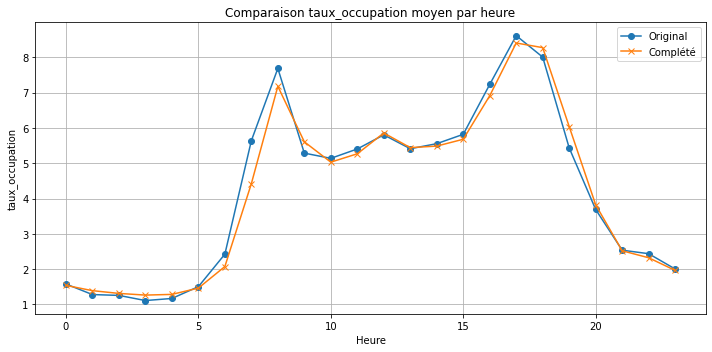

In [251]:
comparer_courbe_par_heure_param(
    df_trafic, df_final,
    col='taux_occupation',
    time_col_orig='horodatage',
    time_col_final='heure_arrondie',
    
)


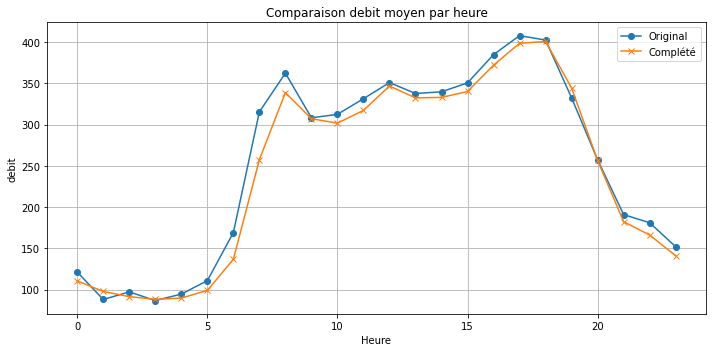

In [252]:
comparer_courbe_par_heure_param(
    df_trafic, df_final,
    col='debit',
    time_col_orig='horodatage',
    time_col_final='heure_arrondie'
)

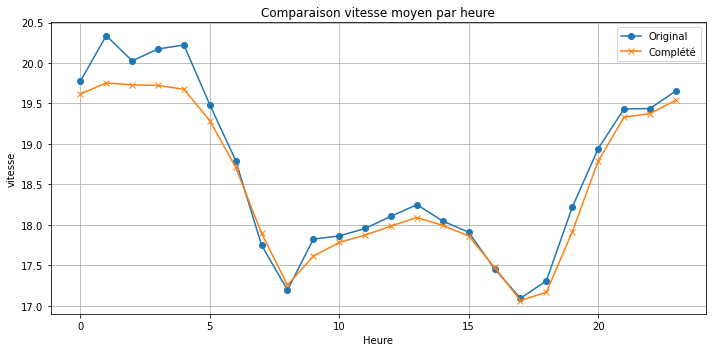

In [271]:
comparer_courbe_par_heure_param(
    df_trafic, df_final,
    col='vitesse',
    time_col_orig='horodatage',
    time_col_final='heure_arrondie'
)

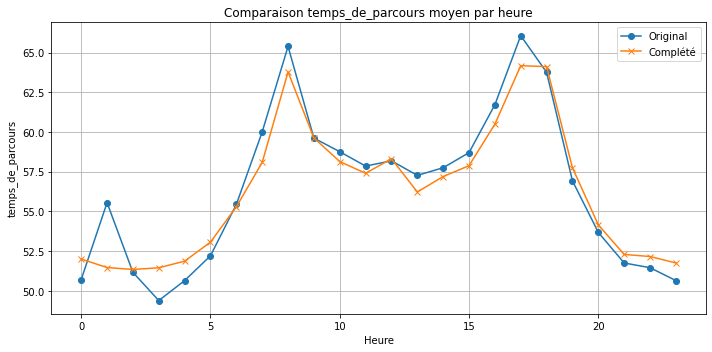

In [272]:
comparer_courbe_par_heure_param(
    df_trafic, df_final,
    col='temps_de_parcours',
    time_col_orig='horodatage',
    time_col_final='heure_arrondie'
)

In [ ]:
def analyser_etat_du_trafic_par_heure(df_orig, df_final, time_col_orig='heure_arrondie', time_col_final='heure_arrondie', max_classes=5):
    """
    Compare la distribution de l'état du trafic par heure entre les données originales et les données complétées,
    avec regroupement des classes rares et visualisation par zones empilées.
    """

    df_orig = df_orig.copy()
    df_final = df_final.copy()

    df_orig['hour'] = pd.to_datetime(df_orig[time_col_orig]).dt.hour
    df_final['hour'] = pd.to_datetime(df_final[time_col_final]).dt.hour

    df_orig['source'] = 'Original'
    df_final['source'] = 'Complété'

    df_all = pd.concat([df_orig[['hour', 'etat_du_trafic', 'source']],
                        df_final[['hour', 'etat_du_trafic', 'source']]])

    # Regrouper les classes rares
    top_classes = df_all['etat_du_trafic'].value_counts().nlargest(max_classes).index
    df_all['etat_du_trafic'] = df_all['etat_du_trafic'].where(df_all['etat_du_trafic'].isin(top_classes), 'Autre')

    # Calcul des proportions
    grouped = (
        df_all
        .groupby(['source', 'hour', 'etat_du_trafic'])
        .size()
        .reset_index(name='count')
    )
    total = grouped.groupby(['source', 'hour'])['count'].transform('sum')
    grouped['proportion'] = grouped['count'] / total

    # Pivot pour graphe area stack
    pivot = grouped.pivot_table(index=['source', 'hour'], columns='etat_du_trafic', values='proportion', fill_value=0)
    pivot = pivot.reset_index()

    # Graphiques par source
    for source in pivot['source'].unique():
        pivot_source = pivot[pivot['source'] == source].set_index('hour')
        pivot_source[pivot_source.columns.difference(['source'])].plot(
            kind='area', stacked=True, title=f"État du trafic par heure - {source}",
            figsize=(10, 5), alpha=0.85
        )
        plt.xlabel("Heure")
        plt.ylabel("Proportion")
        plt.legend(title="État du trafic", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


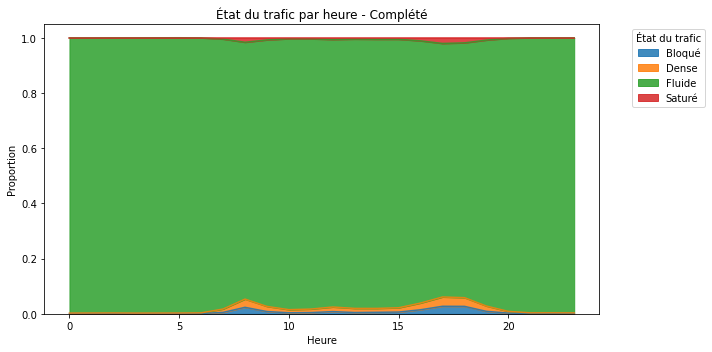

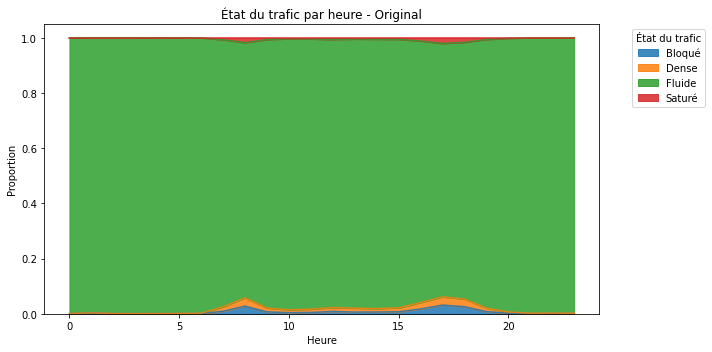

In [ ]:
analyser_etat_du_trafic_par_heure(df_trafic, df_final)

## Nouvelle stratégie de préparation des données

### 1. Standardisation temporelle
- Arrondi des timestamps à la tranche de 15 minutes (`heure_arrondie`)
- Génération d’un DataFrame complet couvrant chaque tronçon à chaque quart d’heure sur toute la période

### 2. Enrichissement des données
- Jointure avec :
  - les données météo (par heure)
  - la pollution
  - les événements à proximité (à ±15 minutes)
  - les calendriers vacances, jours fériés et week-ends

### 3. Remplissage des colonnes fixes
- Colonnes statiques (`longueur`, `type_geo`, `geometrie`, etc.) complétées par la **valeur la plus fréquente par tronçon**

### 4. Stratégie mixte pour les variables temporelles continues
- `debit` et `taux_occupation` :
  - **Interpolation linéaire** uniquement si le trou est court (≤ 1h)
  - Sinon : **moyenne conditionnelle** sur : `tronçon`, `heure`, `jour de la semaine`, `vacances`

### 5. Prédiction des variables dynamiques par modèles Random Forest
- `vitesse` ← `longueur`, `taux_occupation`, `heure`, `jour`, `vacances`, `tronçon`
- `temps_de_parcours` ← `vitesse`, `longueur`, `taux_occupation`, `heure`, `jour`, `vacances`, `tronçon`
- `code_couleur`, `etat_du_trafic` ← `taux_occupation`, `vitesse`, `temps_de_parcours`, `heure`, `jour`, `vacances`, `tronçon`
- Modèles entraînés avec `class_weight='balanced'` pour limiter le biais de classes dominantes

### 6. Contrôles de cohérence
- **Comparaison visuelle des courbes horaires** (`taux_occupation`, `etat_du_trafic`) → cohérence globale préservée
- **Autocorrélation** : vérification de la structure saisonnière
- **Analyse de distribution** : comparaison empilée de `etat_du_trafic` avant/après complétion, avec regroupement des classes rares


## Conclusion

### Analyse des Profils Horaires du Taux d'Occupation et du Débit

Le graphique comparant les profils horaires du taux d'occupation montre une **convergence entre les données originales** et celles complétées. Après l'interpolation et le remplissage des valeurs manquantes, le **comportement temporel** des données reste cohérent avec les tendances horaires. Les variations de taux d'occupation et du débit sont bien préservées, tant sur les heures de pointe que sur les heures creuses, ce qui valide l'efficacité de notre approche mixte d'interpolation et de moyennisation.

En somme, les ajustements appliqués assurent une bonne **continuité des données temporelles** sans altérer les variations naturelles du trafic, tout en offrant un **remplissage cohérent et robuste** des valeurs manquantes.


In [ ]:
#df_final.to_parquet('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/df_final_15min_NoNan_20250505.parquet', index = False)

In [ ]:
#Intégration en base 
def insert_table_to_trafic_db(df, table_name):
    '''
        Insère un DataFrame dans la base de données PostgreSQL de trafic.
        Remplace la table si elle existe déjà.

        Args:
            df (pd.DataFrame): Le DataFrame à insérer.
            table_name (str): Le nom de la table cible dans la base.
    '''
    engine = create_engine(DATABASE_URL)
    df.to_sql(table_name, engine, if_exists='replace', index=False)

insert_table_to_trafic_db(df_final, "donnees_serie_temporelle")
